In order to discover which indicators are more important, we first import all the indicators.

Then train a model with them (basically this is the final model, except for more columns used)

Afterwards, we analyse the model using shap, and print the indicators to be used

In [16]:
import sys

sys.path.append("..")

import time
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from utils import config

In [17]:
%%time
# Load data from the dataset
separator = "','"
sql_read_query = f""" SELECT
                t2.CountryCode as Country,
                t1.Year,
                t3.IndicatorName,
                t1.Value                
                FROM CountryIndicators t1
                LEFT JOIN
                (SELECT ShortName as Country, CountryCode from Countries) t2
                ON t1.CountryCode = t2.CountryCode
                LEFT JOIN
                (SELECT IndicatorCode, IndicatorName from Indicators)t3
                ON t1.IndicatorCode = t3.IndicatorCode
                ;"""

with sqlite3.connect(config.DATABASE_PATH) as conn:
    country_indicators_df = pd.read_sql(sql_read_query,conn)

CPU times: user 12.4 s, sys: 496 ms, total: 12.9 s
Wall time: 12.9 s


In [18]:
# Features List
target = config.TARGET
gdp = config.GDP_GROWTH
pivoted_df = country_indicators_df.pivot(values='Value', index=['Country', 'Year'], columns=['IndicatorName'])

features = pivoted_df.columns.tolist()
print("Features Len:",len(features))

Features Len: 1328


Commented code for previous year -> flag in cli.py, although we didn't see much of a difference

We only use dropna for the rows where our target is missing, otherwise XGBoost can deal with them

In [19]:
# for indicator in features:
#    indicator_1 = country_indicators_df.loc[country_indicators_df["IndicatorName"] == indicator].copy()
#    indicator_1["Year"] += 1
#    indicator_1.set_index(["Country", "Year"], inplace=True)
#    indicator_1.rename(columns={"Value": "Previous "+indicator}, inplace=True)
#    indicator_1.drop(columns=["IndicatorName"], inplace=True)
#    pivoted_df = pivoted_df.join(indicator_1)
# features = pivoted_df.columns.tolist()

target_df = country_indicators_df.loc[country_indicators_df["IndicatorName"] == gdp].copy()
target_df["Year"] -= 1
target_df.set_index(["Country", "Year"], inplace=True)
target_df.rename(columns={"Value": "Next GDP Growth"}, inplace=True)
target_df.drop(columns=["IndicatorName"], inplace=True)
df = pivoted_df.join(target_df)

df = df.dropna(subset=[target])  # Drop row if target is not present
df.shape

(9057, 1329)

In [20]:
# Test-train split
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6339, 1328)
X_test shape: (2718, 1328)
y_train shape: (6339,)
y_test shape: (2718,)


In [21]:
# Init model
xg_reg = xgb.XGBRegressor(**config.XG_PARAMS)

In [22]:
# Train and test
t0 = time.time()
xg_reg.fit(X_train, y_train)
print(f"Elapsed time training: {time.time() - t0} seconds")
t0 = time.time()
xg_reg_y_pred = xg_reg.predict(X_test)
print(f"Elapsed time predicting: {time.time() - t0} seconds")

results_df = X_test
results_df = results_df.drop(columns=features)
results_df["y_real"] = y_test
results_df["y_pred"] = xg_reg_y_pred
results_df["err"] = np.absolute(results_df["y_real"] - results_df["y_pred"])
results_df["%_err"] = ((results_df["err"]) /(np.absolute (results_df["y_real"]))* 100)

print(f"RMSE: {mean_squared_error(y_test, xg_reg_y_pred)**0.5}")
print(f"R^2: {r2_score(y_test, xg_reg_y_pred)}")

results_df 

Elapsed time training: 7.112053155899048 seconds
Elapsed time predicting: 0.041655540466308594 seconds
RMSE: 5.249558541544238
R^2: 0.19971680538239633


,,y_real,y_pred,err,%_err
Country,Year,,,,
ALB,1982,1.104938,3.407495,2.302557,208.387819
GHA,1983,8.647569,-0.219110,8.866679,102.533770
HTI,2007,0.843944,3.202960,2.359016,279.522722
COG,1977,6.359747,1.651719,4.708028,74.028548
MNA,1996,3.052934,4.235005,1.182071,38.719186
...,...,...,...,...,...
CRI,2008,-1.015719,2.609792,3.625511,356.940412
MIC,1986,4.469074,3.739936,0.729139,16.315202
MEX,2004,3.032574,4.476571,1.443997,47.616220


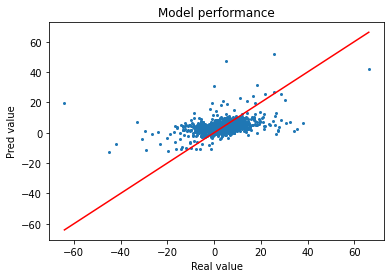

In [23]:
#Predicted Value Plot

fig, ax = plt.subplots()
plot_range = [results_df["y_real"].min(), results_df["y_real"].max()] 
ax.set_title("Model performance")
ax.set_ylabel("Pred value")
ax.set_xlabel("Real value")

ax.scatter(results_df["y_real"], results_df["y_pred"], s=4)
ax.plot(plot_range, plot_range, c="red")
plt.show()

In [24]:
# Prediction for 2011, using the last indicators info
# To do: write the info into data-base
pivoted_df = country_indicators_df.pivot(values='Value', index=['Country', 'Year'], columns=['IndicatorName'])
country_list = pivoted_df.index.unique('Country')

#Dataframe with all the countries
predictions = pd.DataFrame(country_list) 

#for country in country_list: 
predictions["Year"] = 2011
predictions["Value"] = xg_reg.predict(pivoted_df.filter(like = f"{2010}", axis=0))
predictions.rename(columns={'Country': 'CountryCode'}, inplace=True)
predictions

,CountryCode,Year,Value
0,ABW,2011,2.664822
1,ADO,2011,0.225986
2,AFG,2011,7.356856
3,AGO,2011,3.231156
4,ALB,2011,2.966302
...,...,...,...
242,YEM,2011,4.569973
243,ZAF,2011,1.658938
244,ZAR,2011,6.243429
245,ZMB,2011,8.978580


In [25]:
with sqlite3.connect(config.DATABASE_PATH) as conn:
    predictions.to_sql('EstimatedGDPGrowth', conn, if_exists='replace', index = False)

In [26]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)

In [27]:
%%time
shap_values = explainer.shap_values(X_test)

CPU times: user 5.8 s, sys: 0 ns, total: 5.8 s
Wall time: 757 ms


Shap gives an overview of the most important parameters and how they contribute to the model

We comment on them on the final_model notebook

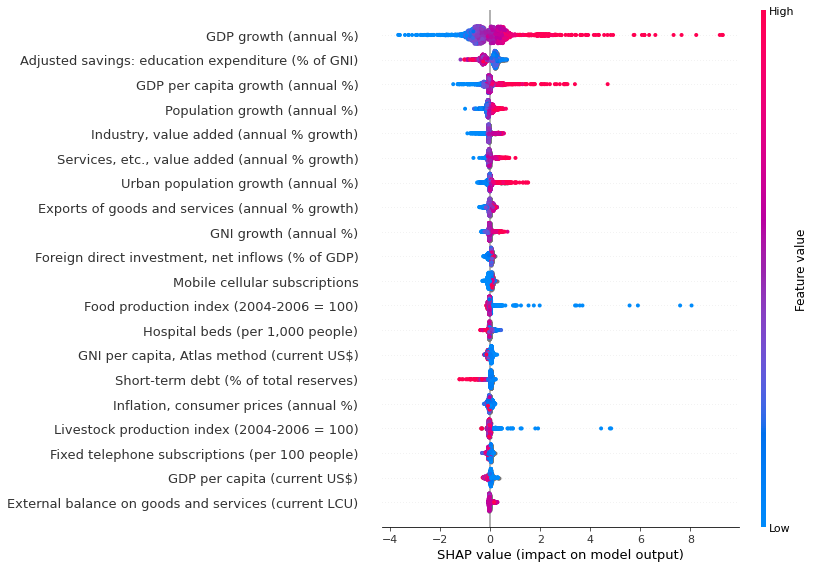

In [28]:
shap.summary_plot(shap_values, X_test,feature_names=features)

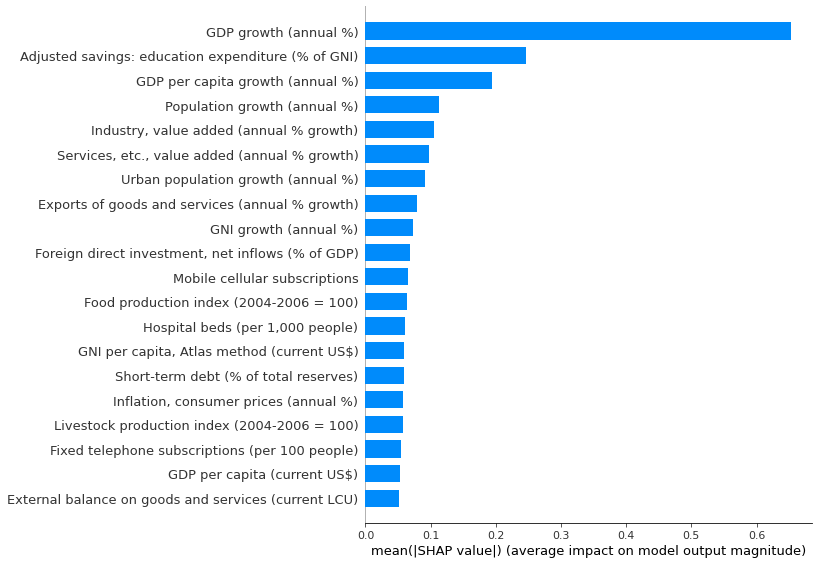

In [29]:
shap.summary_plot(shap_values, X_test, plot_type="bar",feature_names=features)

We can export a list of the 50 most important indicators, which we then paste in the config file to be imported in the final model

In [30]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
important_features = feature_importance['col_name'].head(50).values.tolist()
important_features

['GDP growth (annual %)',
 'Adjusted savings: education expenditure (% of GNI)',
 'GDP per capita growth (annual %)',
 'Population growth (annual %)',
 'Industry, value added (annual % growth)',
 'Services, etc., value added (annual % growth)',
 'Urban population growth (annual %)',
 'Exports of goods and services (annual % growth)',
 'GNI growth (annual %)',
 'Foreign direct investment, net inflows (% of GDP)',
 'Mobile cellular subscriptions',
 'Food production index (2004-2006 = 100)',
 'Hospital beds (per 1,000 people)',
 'GNI per capita, Atlas method (current US$)',
 'Short-term debt (% of total reserves)',
 'Inflation, consumer prices (annual %)',
 'Livestock production index (2004-2006 = 100)',
 'Fixed telephone subscriptions (per 100 people)',
 'GDP per capita (current US$)',
 'External balance on goods and services (current LCU)',
 'S&P Global Equity Indices (annual % change)',
 'Agriculture, value added (annual % growth)',
 'Labor force participation rate, male (% of male pop